In [9]:
# ! pip install seaborn
# ! pip install pyvis

In [1]:
import numpy as np
import seaborn as sns
import pickle
import pandas as pd
import plotly.express as px
from pyvis.network import Network
from collections import defaultdict
import json

In [197]:
# df = pd.read_csv('cooccurence_fraction_24576_features_101376_tokens_0.5_activationthreshold_0.1_filterthreshold.csv')
# df = pd.read_feather('mutual_information_24576_features_18432_tokens_0.5_activationthreshold.feather')
df = pd.read_csv('mutual_information_24576_features_101376_tokens_0.5_activationthreshold_0.1_filterthreshold.csv')

In [198]:
print(df.shape)
df.head()
df.columns = ['id', 'layer_A', 'layer_B', 'feature_A', 'feature_B', 'weight']

(8301015, 6)


In [258]:
df.shape

(36194, 6)

In [257]:
df.head()

,id,layer_A,layer_B,feature_A,feature_B,weight
110,110,0,1,7,24049,1.0
111,111,0,1,8,18695,1.0
139,139,0,1,15,20443,1.0
162,162,0,1,19,2308,1.0
163,163,0,1,19,4625,1.0


In [200]:
mw = np.exp(df.weight.max())

In [201]:
df['weight'] = df.weight.apply(lambda w: np.exp(w) / mw)

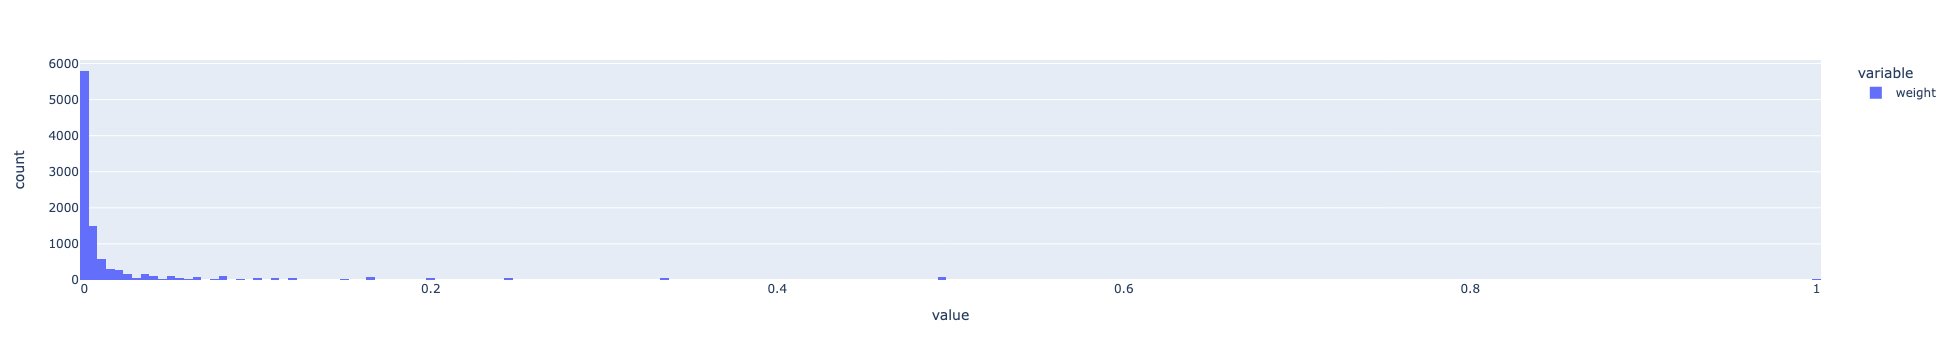

In [202]:
px.histogram(df.sample(10_000).weight)

In [203]:
# Filter based on feature
# df = df[((df.layer_B == 9) & (df.feature_B == 14494))]

In [259]:
df[(df.layer_B == 4) & (df.feature_B == 7279)]

,id,layer_A,layer_B,feature_A,feature_B,weight


In [191]:
# L3/F5823
# df[((df.layer_B == 7) & (df.feature_B == 8457))].sort_values(by='weight', ascending=False)

In [204]:
threshold = 0.9
df = df[df.weight >= threshold]
df.shape

(36194, 6)

In [194]:
# df['feature_A_id'] = df.apply(lambda row: f"L{int(row.layer_A)}/F{int(row.feature_A)}", axis=1)
# df['feature_B_id'] = df.apply(lambda row: f"L{int(row.layer_B)}/F{int(row.feature_B)}", axis=1)

In [195]:
# features_A_with_counts = dict(df.feature_A_id.value_counts())
# features_B_with_counts = dict(df.feature_B_id.value_counts())
# features_with_counts = {**features_A_with_counts, **features_B_with_counts}

In [29]:
# px.histogram(features_with_counts.values())

In [205]:
df.head()

,id,layer_A,layer_B,feature_A,feature_B,weight
110,110,0,1,7,24049,1.0
111,111,0,1,8,18695,1.0
139,139,0,1,15,20443,1.0
162,162,0,1,19,2308,1.0
163,163,0,1,19,4625,1.0


## Creating and analysing graphs

In [206]:
connections_lookup = defaultdict(list)
nodes = {}

for _, row in df.iterrows():
    n1_id = int(f"{int(row.layer_A)}{int(row.feature_A)}")
    n1_label = f"L{int(row.layer_A)}/F{int(row.feature_A)}"
    n2_id = int(f"{int(row.layer_B)}{int(row.feature_B)}")
    n2_label = f"L{int(row.layer_B)}/F{int(row.feature_B)}"
    connections_lookup[n2_label].append({
        "n1_id": n2_id,
        "n1_label": n2_label,
        "n2_id": n1_id,
        "n2_label": n1_label,
        "weight": round(row.weight, 4)
    })
    nodes[n1_label] = {}
    nodes[n2_label] = {}

In [207]:
len(connections_lookup), len(nodes)

(29108, 36704)

### Centrality Measures (Degree Centrality)

In [208]:
import networkx as nx

In [209]:
G = nx.DiGraph()
edges = []

In [210]:
for _, row in df.iterrows():
    G.add_edge(f"L{int(row.layer_A)}/F{int(row.feature_A)}", f"L{int(row.layer_B)}/F{int(row.feature_B)}", weight=row.weight)

    n1_id = int(f"{int(row.layer_A)}{int(row.feature_A)}")
    n1_label = f"L{int(row.layer_A)}/F{int(row.feature_A)}"
    n2_id = int(f"{int(row.layer_B)}{int(row.feature_B)}")
    n2_label = f"L{int(row.layer_B)}/F{int(row.feature_B)}"
    
    edges.append({
        "n1_id": n1_id,
        "n1_label": n1_label,
        "n2_id": n2_id,
        "n2_label": n2_label,
        "weight": round(row.weight, 4)
    })

In [211]:
degree_centrality = nx.degree_centrality(G)

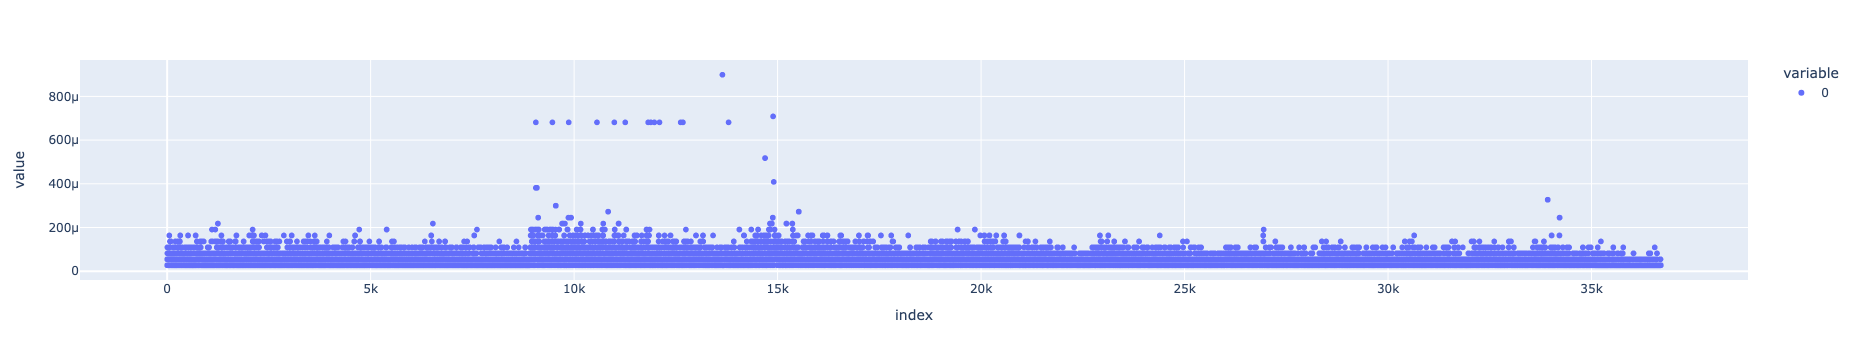

In [212]:
px.scatter(degree_centrality.values())

In [213]:
def plot_layered_graph_pyvis(edges, feature_id):
    # Create a network object with specific size
    net = Network(height="750px", width="100%", notebook=True, bgcolor="#222222", font_color="white", cdn_resources="remote")
    
    # Add nodes and edges with selective visibility based on weight
    for d in edges:
        net.add_node(d['n1_id'], label=d['n1_label'], title=d['n1_label'])
        net.add_node(d['n2_id'], label=d['n2_label'], title=d['n2_label'])
        net.add_edge(d['n1_id'], d['n2_id'], value=d['weight'], title=f"Weight: {d['weight']:.3f}")

    # Display the network
    net.show(f"{feature_id.replace("/", ".")}.html")

In [214]:
# sorted(degree_centrality.items(), key=lambda t: t[1], reverse=True)[:10]

In [215]:
# edges_for_feature = []
# feature_id = 'L3/F5823'

# for d in edges:
#     if d['n1_label'] == feature_id or d['n2_label'] == feature_id:
#         edges_for_feature.append(d)

In [216]:
# plot_layered_graph_pyvis(edges_for_feature, feature_id)

In [217]:
for n, c in degree_centrality.items():
    nodes[n]['degree_centrality'] = c

In [218]:
for n, deg in G.degree():
    nodes[n]['degree'] = deg

In [219]:
in_degree_centrality = nx.in_degree_centrality(G)

for n, cd in in_degree_centrality.items():
    nodes[n]['in_degree_centrality'] = cd

In [220]:
out_degree_centrality = nx.out_degree_centrality(G)

for n, cd in out_degree_centrality.items():
    nodes[n]['out_degree_centrality'] = cd

In [221]:
# betweenness_centrality = nx.betweenness_centrality(G)

# for n, bc in betweenness_centrality.items():
#     nodes[n]['betweenness_centrality'] = bc

In [222]:
pagerank = nx.pagerank(G)

for n, pr in pagerank.items():
    nodes[n]['pagerank'] = pr

In [223]:
with open('nodes_backwards.json', 'w') as fw:
    json.dump(nodes, fw)

with open('edges_backwards.json', 'w') as fw:
    json.dump(edges, fw)

with open('connections_lookup_by_feature_backwards.json', 'w') as fw:
    json.dump(connections_lookup, fw)

In [224]:
formatted_nodes = [{'feature_id': k, **v} for k, v in nodes.items()]
nodes_df = pd.DataFrame(formatted_nodes)

In [225]:
nodes_df.head()

,feature_id,degree_centrality,degree,in_degree_centrality,out_degree_centrality,pagerank
0,L0/F7,0.000027,1,0.000000,0.000027,0.000010
1,L1/F24049,0.000054,2,0.000027,0.000027,0.000018
2,L0/F8,0.000027,1,0.000000,0.000027,0.000010
3,L1/F18695,0.000054,2,0.000027,0.000027,0.000018
4,L0/F15,0.000027,1,0.000000,0.000027,0.000010


### Let's find some interesting features to trace

In [226]:
nodes_df[nodes_df.feature_id.str.contains('L0')].sort_values(by='degree', ascending=False).head(5)

,feature_id,degree_centrality,degree,in_degree_centrality,out_degree_centrality,pagerank
7613,L0/F20722,0.000191,7,0.0,0.000191,0.00001
4720,L0/F12549,0.000191,7,0.0,0.000191,0.00001
2100,L0/F5278,0.000191,7,0.0,0.000191,0.00001
1184,L0/F2928,0.000191,7,0.0,0.000191,0.00001
3628,L0/F9502,0.000163,6,0.0,0.000163,0.00001


In [227]:
top_feature_id = 'L0/F13303'
stack = [top_feature_id]
feature_trace = []

while stack:
    feature_id = stack.pop()
    for connected_feature in connections_lookup[feature_id]:
        feature_trace.append(connected_feature)
        stack.append(connected_feature['n2_label'])

In [228]:
len(feature_trace)

0

### Format the tree for the visualisation library echarts

In [269]:
# def build_tree(edges, max_nodes=100):
#     # Create a dictionary to store nodes and their children
#     nodes = {}
#     node_count = 0

#     # Create a dictionary to store the incoming edges for each node
#     incoming_edges = defaultdict(list)
#     for edge in edges:
#         incoming_edges[edge['n2_id']].append(edge)

#     # Iterate over the edges and build the tree structure
#     for edge in edges:
#         parent_id = edge['n1_id']
#         parent_label = edge['n1_label']
#         child_id = edge['n2_id']
#         child_label = edge['n2_label']
#         weight = edge['weight']

#         # Add parent node if it doesn't exist
#         if parent_id not in nodes:
#             nodes[parent_id] = {'name': parent_label, 'value': weight, 'children': [], 'lineStyle': {'color': 'black', 'width': 2.0}}
#             node_count += 1

#         # Add child node if it doesn't exist
#         if child_id not in nodes:
#             nodes[child_id] = {'name': child_label, 'value': weight, 'children': [], 'lineStyle': {'color': 'black', 'width': 2.0}}
#             node_count += 1

#         # Check if the maximum number of nodes is exceeded
#         if node_count > max_nodes:
#             print(f"Maximum number of nodes ({max_nodes}) exceeded. Stopping tree construction.")
#             return None

#         # Add child to parent's children list
#         nodes[parent_id]['children'].append(nodes[child_id])

#     # Find the root node (node with no incoming edges)
#     root_id = None
#     for node_id in nodes:
#         if node_id not in incoming_edges:
#             root_id = node_id
#             break

#     # Return the root node of the tree
#     return nodes[root_id]

def build_tree(edges, max_nodes=100):
    # Create a dictionary to store nodes and their children
    nodes = {}
    node_count = 0

    # Create a dictionary to store the incoming edges for each node
    incoming_edges = defaultdict(list)
    for edge in edges:
        incoming_edges[edge['n2_id']].append(edge)

    # Iterate over the edges and build the tree structure
    for edge in edges:
        parent_id = edge['n1_id']
        parent_label = edge['n1_label']
        child_id = edge['n2_id']
        child_label = edge['n2_label']
        weight = edge['weight']

        # Add parent node if it doesn't exist
        if parent_id not in nodes:
            nodes[parent_id] = {'name': parent_label, 'value': weight, 'children': {}, 'lineStyle': {'color': 'black', 'width': 2.0}}
            node_count += 1

        # Add child node if it doesn't exist
        if child_id not in nodes:
            nodes[child_id] = {'name': child_label, 'value': weight, 'children': {}, 'lineStyle': {'color': 'black', 'width': 2.0}}
            node_count += 1

        # Check if the maximum number of nodes is exceeded
        if node_count > max_nodes:
            print(f"Maximum number of nodes ({max_nodes}) exceeded. Stopping tree construction.")
            return None

        # Add child to parent's children dictionary if it doesn't exist
        if child_id not in nodes[parent_id]['children']:
            nodes[parent_id]['children'][child_id] = nodes[child_id]

    # Find the root node (node with no incoming edges)
    root_id = None
    for node_id in nodes:
        if node_id not in incoming_edges:
            root_id = node_id
            break

    # Convert children dictionaries to lists
    def convert_children(node):
        if isinstance(node['children'], dict):
            node['children'] = list(node['children'].values())

        for child in node['children']:
            convert_children(child)

    convert_children(nodes[root_id])

    # Return the root node of the tree
    return nodes[root_id]

def create_feature_trace(start_feature):
    stack = [start_feature]
    feature_trace = []
    # seen = set()
    unique_features = set()
    i = 0
    
    while stack:
        feature_id = stack.pop()
        # seen.add(feature_id)
        unique_features.add(feature_id)
        for connected_feature in connections_lookup[feature_id]:
            feature_trace.append(connected_feature)
            stack.append(connected_feature['n2_label'])

    return feature_trace, len(unique_features)

In [35]:
# tree = build_tree(feature_trace)
# with open(f"{start_feature.replace('/', '-')}_tree.json", 'w') as fw:
#     json.dump(tree, fw)

In [36]:
# plot_layered_graph_pyvis(feature_trace, start_feature)

### Preparing all features

In [261]:
nodes_df.head()

,feature_id,degree_centrality,degree,in_degree_centrality,out_degree_centrality,pagerank,degree_centrality_rank,degree_rank,pagerank_rank
0,L0/F7,0.000027,1,0.000000,0.000027,0.000010,18/18,18/18,1145/1145
1,L1/F24049,0.000054,2,0.000027,0.000027,0.000018,17/18,17/18,1114/1145
2,L0/F8,0.000027,1,0.000000,0.000027,0.000010,18/18,18/18,1145/1145
3,L1/F18695,0.000054,2,0.000027,0.000027,0.000018,17/18,17/18,1114/1145
4,L0/F15,0.000027,1,0.000000,0.000027,0.000010,18/18,18/18,1145/1145


In [270]:
unique_degree_centralities = set(nodes_df.degree_centrality.tolist())
n_unique_degree_centralities = len(unique_degree_centralities)
degree_centralities_to_rank = {dc: f"{i + 1}/{n_unique_degree_centralities}" for i, dc in enumerate(sorted(unique_degree_centralities, reverse=True))}

unique_degrees = set(nodes_df.degree.tolist())
n_unique_degrees = len(unique_degrees)
degrees_to_rank = {dc: f"{i + 1}/{n_unique_degrees}" for i, dc in enumerate(sorted(unique_degrees, reverse=True))}

# unique_betweenness_centralities = set(nodes_df.betweenness_centrality.tolist())
# n_unique_betweenness_centralities = len(unique_betweenness_centralities)
# betweenness_centralities_to_rank = {dc: f"{i + 1}/{n_unique_betweenness_centralities}" for i, dc in enumerate(sorted(unique_betweenness_centralities, reverse=True))}

unique_pageranks = set(nodes_df.pagerank.tolist())
n_unique_pageranks = len(unique_pageranks)
pagerank_to_rank = {dc: f"{i + 1}/{n_unique_pageranks}" for i, dc in enumerate(sorted(unique_pageranks, reverse=True))}

In [271]:
nodes_df['degree_centrality_rank'] = nodes_df.degree_centrality.map(degree_centralities_to_rank)
nodes_df['degree_rank'] = nodes_df.degree.map(degrees_to_rank)
# nodes_df['betweenness_centrality_rank'] = nodes_df.betweenness_centrality.map(betweenness_centralities_to_rank)
nodes_df['pagerank_rank'] = nodes_df.pagerank.map(pagerank_to_rank)

In [272]:
from tqdm.notebook import tqdm

In [273]:
nodes_df.head()

,feature_id,degree_centrality,degree,in_degree_centrality,out_degree_centrality,pagerank,degree_centrality_rank,degree_rank,pagerank_rank
0,L0/F7,0.000027,1,0.000000,0.000027,0.000010,18/18,18/18,1145/1145
1,L1/F24049,0.000054,2,0.000027,0.000027,0.000018,17/18,17/18,1114/1145
2,L0/F8,0.000027,1,0.000000,0.000027,0.000010,18/18,18/18,1145/1145
3,L1/F18695,0.000054,2,0.000027,0.000027,0.000018,17/18,17/18,1114/1145
4,L0/F15,0.000027,1,0.000000,0.000027,0.000010,18/18,18/18,1145/1145


In [274]:
df.sort_values(by='weight', ascending=False)

,id,layer_A,layer_B,feature_A,feature_B,weight
110,110,0,1,7,24049,1.0
2080192,2080192,4,5,11690,8565,1.0
2077438,2077438,4,5,11601,6159,1.0
2077546,2077546,4,5,11604,4192,1.0
2078781,2078781,4,5,11655,7091,1.0
...,...,...,...,...,...,...
749993,749993,1,2,24263,16839,1.0
749964,749964,1,2,24261,23449,1.0
749955,749955,1,2,24260,12848,1.0
749952,749952,1,2,24259,4896,1.0


In [ ]:
# df[(df.layer_B == 7) & (df.feature_B == 14571)]

In [275]:
%%time
top_k = 100
key_by = 'pagerank'
features = []

feature_allowlist = ['L9/F14494']

# for _, row in tqdm(nodes_df.sort_values(by=key_by, ascending=False).head(top_k).iterrows()):
for _, row in tqdm(nodes_df.sample(top_k).iterrows()):
# for _, row in tqdm(nodes_df[nodes_df.feature_id.isin(feature_allowlist)].iterrows()):
    feature_trace, n_unique_features = create_feature_trace(row.feature_id)
    # print(row.feature_id, len(feature_trace))
    if len(feature_trace) > 0:
        tree = build_tree(feature_trace)
        if tree is None:
            continue
    else:
        continue
        
    features.append({
        'feature_id': row.feature_id,
        'degree_centrality': row.degree_centrality,
        'degree': row.degree,
        'in_degree_centrality': row.in_degree_centrality,
        'out_degree_centrality': row.out_degree_centrality,
        'degree_centrality_rank': row.degree_centrality_rank,
        'degree_rank': row.degree_rank,
        # 'betweenness_centrality': row.betweenness_centrality,
        # 'betweenness_centrality_rank': row.betweenness_centrality_rank,
        'pagerank_rank': row.pagerank_rank,
        'pagerank': row.pagerank,
        'trace_size': len(feature_trace) + 1,
        "n_unique_features": n_unique_features,
        'tree': tree
    })

0it [00:00, ?it/s]

CPU times: user 18 ms, sys: 7.74 ms, total: 25.7 ms
Wall time: 37.4 ms


In [253]:
# features = sorted(features, key=lambda d: d['trace_size'], reverse=True)

In [276]:
features = {feat['feature_id']: feat for feat in features}

In [277]:
with open('features.json', 'w') as fw:
    json.dump(features, fw)

In [278]:
! du -sh features.json

136K	features.json


### Loading info from neuronpedia

In [194]:
import urllib
import json

In [225]:
def get_neuronpedia_quick_list(
    features: list[int],
    layer: int,
    model: str = "gpt2-small",
    dataset: str = "res-jb",
    name: str = "temporary_list",
):
    url = "https://neuronpedia.org/quick-list/"
    name = urllib.parse.quote(name)
    url = url + "?name=" + name
    list_feature = [
        {"modelId": model, "layer": f"{layer}-{dataset}", "index": str(feature)}
        for feature in features
    ]
    print(list_feature)
    url = url + "&features=" + urllib.parse.quote(json.dumps(list_feature))
    print(url)
    # webbrowser.open(url)

In [329]:
# get_neuronpedia_quick_list([2, 129], 8)

In [192]:
def get_url(features):
    url = "https://neuronpedia.org/quick-list/?name=feature-comparison-temp"
    formatted_features = [
        {"modelId": "gpt2-small", "layer": f"{feature['layer']}-res-jb", "index": feature['feature']}
        for feature in features
    ]
    url = url + "&features=" + urllib.parse.quote(json.dumps(formatted_features))
    return url

In [195]:
features = [
    {'layer': '9', 'feature': '14494'},
    {'layer': '8', 'feature': '17588'},
    {'layer': '8', 'feature': '21469'},
    {'layer': '8', 'feature': '4190'}
]
get_url(features)

'https://neuronpedia.org/quick-list/?name=feature-comparison-temp&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2214494%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%228-res-jb%22%2C%20%22index%22%3A%20%2217588%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%228-res-jb%22%2C%20%22index%22%3A%20%2221469%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%228-res-jb%22%2C%20%22index%22%3A%20%224190%22%7D%5D'